# __Step 4.4: Topic over time__

Goals here:
- Analyze topics over time

Considerations:
- Time interval
  - The `topic_over_time` method doc in BERTopic has the following disclaimer: "Make sure to use a limited number of unique timestamps (<100) as the c-TF-IDF representation will be calculated at each single unique timestamp. Having a large number of unique timestamps can take some time to be calculated. Moreover, there aren't many use-cased where you would like to see the difference in topic representations over more than 100 different timestamps."
  - In light of this, the timestamps are generate at the year level.
    - Also realize that there are docs since 1917 but few of them in the early years. So pool docs before 1970 as one bin with a timestamp 1969.
    - There are very few 2021 articles (58) included due to publicaton time change. They are counted as 2020.
- Ok, after doing a `topic_over_time` run, I realize that the number of docs differ so much between the annual bins, it creates a whole host of issues. So do this instead:
  - Get a sorted timestamps list, without applying any thresholding.
  - Get every two percentile timestamp values and cut the whole dataset into 50 similar sized bins.
  - Note that the sizes are very similar but not the same because how I put things into bins.

## ___Set up___

### Module import

In [34]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from bertopic import BERTopic
from tqdm import tqdm
from datetime import datetime
from bisect import bisect
from sklearn.preprocessing import normalize
from time import time

### Key variables

In [2]:
# Reproducibility
seed = 20220609

# Setting working directory
proj_dir   = Path.home() / "projects/plant_sci_hist"
work_dir   = proj_dir / "4_topic_model/4_4_over_time"
work_dir.mkdir(parents=True, exist_ok=True)

# plant science corpus
dir25       = proj_dir / "2_text_classify/2_5_predict_pubmed"
corpus_file = dir25 / "corpus_plant_421658.tsv.gz"

# processed docs
dir41            = proj_dir / "4_topic_model/4_1_compare_models"
docs_clean_file  = dir41 / "corpus_plant_421658_proc_txt.pkl"

# saved model, probability, and embedding files
dir42            = proj_dir / "4_topic_model/4_2_outlier_assign"
topic_model_file = dir42 / "topic_model_updated"
prob_file        = dir42 / "probs.pickle"
embedding_file   = dir42 / "embeddings_scibert.pickle"

# So PDF is saved in a format properly
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "sans-serif"

## ___Load data___

### Load original corpus

In [3]:
df_corpus = pd.read_csv(corpus_file, sep='\t')
df_corpus.head(3)

,Unnamed: 0,PMID,Date,Journal,Title,Abstract,QualifiedName,txt,reg_article,y_prob,y_pred
0,3,61,1975-12-11,Biochimica et biophysica acta,Identification of the 120 mus phase in the dec...,After a 500 mus laser flash a 120 mus phase in...,spinach,Identification of the 120 mus phase in the dec...,1,0.716394,1
1,4,67,1975-11-20,Biochimica et biophysica acta,Cholinesterases from plant tissues. VI. Prelim...,Enzymes capable of hydrolyzing esters of thioc...,plant,Cholinesterases from plant tissues. VI. Prelim...,1,0.894874,1
2,9,283,1975-01-01,Folia microbiologica,"Fructose 1,6-bisphosphate aldolase activity of...",FDP aldolase was found to be present in the ce...,sesbania,"Fructose 1,6-bisphosphate aldolase activity of...",1,0.901070,1


In [4]:
df_corpus.shape

(421658, 11)

### Load topic model and probability

In [5]:
# Load topic model
topic_model = BERTopic.load(topic_model_file)

In [6]:
# load prob
with open(prob_file, "rb") as f:
  probs = pickle.load(f)

### Load cleaned data

In [7]:
with open(docs_clean_file, "rb") as f:
  docs = pickle.load(f)

## ___Process datetime___

### Create a timestamps list for plotting article numbers

Note that the timestamp will be generated at the year level.
- pool docs before 1970 as one bin with a timestamp 1969.
- This is for plotting purpose.

In [8]:
# Get pandas series dates
dates = df_corpus['Date']
dates[0], dates[1]

('1975-12-11', '1975-11-20')

In [9]:
ts_for_plot = []
docs_yr     = [] # a list of years
early_doc   = {} # {year: count}
for date in dates:
  [yr, mo, da] = date.split('-') # year, month, day
  # docs from the same year has the same timestamp
  yr = int(yr)
  docs_yr.append(yr)

  # Create 
  if yr not in early_doc:
    early_doc[yr] = 1
  else:
    early_doc[yr]+= 1

  # Set year before 1970 as 1969.
  if yr < 1970:  
    yr = 1969

  # Set year after 2020 as 2020. There are 58 instances
  if yr > 2020:  
    yr = 2020

  dt   = datetime(yr, 1, 1)
  ts   = dt.timestamp()
  ts_for_plot.append(ts)
len(ts_for_plot)

421658

In [10]:
docs_year_array = np.unique(np.array(docs_yr), return_counts=True)
docs_year_df    = pd.DataFrame(docs_year_array[1], columns=["Count"],
                               index=docs_year_array[0])

In [11]:
docs_year_df.loc[1965]

Count    97
Name: 1965, dtype: int64

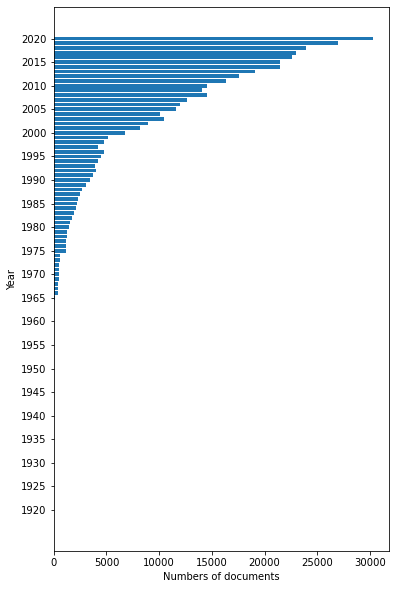

In [12]:
# without log
plt.figure(figsize=(6,10))
plt.barh(docs_year_array[0], docs_year_array[1])
plt.ylabel('Year')
plt.xlabel('Numbers of documents')
plt.yticks(range(1920, 2021, 5))
plt.savefig(work_dir / 'figure4_4_num_docs_per_year.pdf')

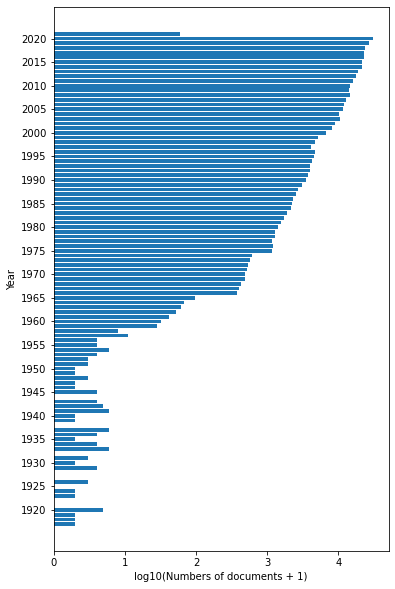

In [13]:
# logged
plt.figure(figsize=(6,10))
plt.barh(docs_year_array[0], np.log10(docs_year_array[1]+1))
plt.ylabel('Year')

# +1 so the x-axis value is not zero.
plt.xlabel('log10(Numbers of documents + 1)')
plt.yticks(range(1920, 2021, 5))
plt.savefig(work_dir / 'figure4_4_num_docs_per_year_logged.pdf')

### Spot check timestamp values

In [14]:
rand_ints = np.random.randint(df_corpus.shape[0], size=20)
for rand_int in rand_ints:
  date = df_corpus['Date'][rand_int]
  ts   = ts_for_plot[rand_int]
  print(date, "<-->", datetime.fromtimestamp(ts), ts)

2002-05-23 <--> 2002-01-01 00:00:00 1009861200.0
2006-12-21 <--> 2006-01-01 00:00:00 1136091600.0
2012-09-12 <--> 2012-01-01 00:00:00 1325394000.0
2014-03-13 <--> 2014-01-01 00:00:00 1388552400.0
2019-02-14 <--> 2019-01-01 00:00:00 1546318800.0
1999-01-08 <--> 1999-01-01 00:00:00 915166800.0
2012-08-07 <--> 2012-01-01 00:00:00 1325394000.0
2019-03-16 <--> 2019-01-01 00:00:00 1546318800.0
2019-09-29 <--> 2019-01-01 00:00:00 1546318800.0
1986-05-05 <--> 1986-01-01 00:00:00 504939600.0
2015-08-04 <--> 2015-01-01 00:00:00 1420088400.0
2016-01-20 <--> 2016-01-01 00:00:00 1451624400.0
2020-02-23 <--> 2020-01-01 00:00:00 1577854800.0
1991-11-01 <--> 1991-01-01 00:00:00 662706000.0
1991-10-05 <--> 1991-01-01 00:00:00 662706000.0
2018-02-08 <--> 2018-01-01 00:00:00 1514782800.0
2019-03-07 <--> 2019-01-01 00:00:00 1546318800.0
2014-09-30 <--> 2014-01-01 00:00:00 1388552400.0
2011-01-12 <--> 2011-01-01 00:00:00 1293858000.0
2019-10-23 <--> 2019-01-01 00:00:00 1546318800.0


In [15]:
min(ts_for_plot), max(ts_for_plot), datetime.fromtimestamp(min(ts_for_plot))

(-31518000.0, 1577854800.0, datetime.datetime(1969, 1, 1, 0, 0))

### Get the binned timestamp values

So the bins have similar numbers of docs.
- For this a new timestamp list is generated

In [16]:
# Turn all dates into timestamps 
ts_for_bins = []
for date in dates:
  [yr, mo, da] = date.split('-') # year, month, day
  dt   = datetime(int(yr), int(mo), int(da))
  ts   = dt.timestamp()
  ts_for_bins.append(ts)

In [17]:
ts_for_bins.sort()

In [18]:
# bin size
bin_size       = int(len(ts_for_bins)/50)

# index values of every 2 percentile (because the data is broken into 50 parts)
bin_idxs       = [idx for idx in range(0, len(ts_for_bins), bin_size)]

# timestamp values at bin_idxs
bin_timestamps = [ts_for_bins[idx] for idx in bin_idxs]

# Modify the last value to be the max timestamp value + 1. This is otherwise
# because of the bin_size is rounded down the last value be smaller than the max
# timestamp values. Also, +1 to the max value, otherwise, the last entries will
# be in its own bin.
max_timestamp      = max(ts_for_bins) + 1
bin_timestamps[-1] = max_timestamp

# dates correspond to the different timestamp
bin_dates      = [datetime.fromtimestamp(ts) for ts in bin_timestamps]

# Put idx, timestamp, and date into a dataframe and save it.
bin_df         = pd.DataFrame(list(zip(bin_idxs, bin_timestamps, bin_dates)),
            columns=['bin_start_idx', 'bin_start_timestamp', 'bin_start_date'])
bin_df.to_csv(work_dir / "table4_4_bin_timestamp_date.tsv", sep='\t')

In [19]:
bin_df.head(), bin_df.tail()

(   bin_start_idx  bin_start_timestamp bin_start_date
 0              0        -1.646248e+09     1917-11-01
 1           8433         2.507508e+08     1977-12-12
 2          16866         4.258800e+08     1983-07-01
 3          25299         5.468400e+08     1987-05-01
 4          33732         6.389460e+08     1990-04-01,
     bin_start_idx  bin_start_timestamp      bin_start_date
 46         387918         1.574053e+09 2019-11-18 00:00:00
 47         396351         1.583557e+09 2020-03-07 00:00:00
 48         404784         1.592712e+09 2020-06-21 00:00:00
 49         413217         1.601438e+09 2020-09-30 00:00:00
 50         421650         1.609477e+09 2021-01-01 00:00:01)

### Generate the binned timestamps

In [20]:
# Assign new timestamps based on the bin timestamp values
ts_in_bins = []
for date in dates:
  [yr, mo, da] = date.split('-') # year, month, day
  dt   = datetime(int(yr), int(mo), int(da))
  ts   = dt.timestamp()

  bin_idx = bisect(bin_timestamps, ts)

  if bin_idx < len(bin_timestamps):
    ts2     = bin_timestamps[bin_idx]
  # Deal with the last bin
  else:
    ts2     = datetime(2022, 12, 31).timestamp()
  ts_in_bins.append(ts2) 

## ___Topic over time___

### Setup `topics_over_time`

Bertopic [doc](https://maartengr.github.io/BERTopic/api/bertopic.html#bertopic._bertopic.BERTopic.topics_over_time)
- docs,	List[str]: docs used when calling either fit or fit_transform
  - Set to `df_corpus[txt]`
- topics, List[int]: topics that were returned when calling either fit or fit_transform
  - See `script_4_3` using np.argmax to get topics
- timestamps,	Union[List[str], List[int]]: The timestamp of each document. This can be either a list of strings or ints.
  - Set to `timestamps` 
- nr_bins, int: The number of bins you want to create for the timestamps.
  - From 1969 to 2000, so `52` bins
- datetime_format, str: The datetime format of the timestamps if they are strings, eg “%d/%m/%Y”. Set this to None if you want to have it automatically detect the format. 
  - Set to `None`
- evolution_tuning,	bool: Fine-tune each topic representation at timestamp t by averaging its c-TF-IDF matrix with the c-TF-IDF matrix at timestamp t-1. This creates evolutionary topic representations.
  - Set to `True`
- global_tuning, bool: Fine-tune each topic representation at timestamp t by averaging its c-TF-IDF matrix with the global c-TF-IDF matrix. Turn this off if you want to prevent words in topic representations that could not be found in the documents at timestamp t.
  - Set to `True`

In [21]:
probability_threshold = np.percentile(probs, 95)
topics = [np.argmax(prob) if max(prob) >= probability_threshold else -1 
                                                            for prob in probs]

In [22]:
np.unique(np.array(ts_in_bins), return_counts=True)

(array([2.5075080e+08, 4.2588000e+08, 5.4684000e+08, 6.3894600e+08,
        7.1264160e+08, 7.7839200e+08, 8.3619360e+08, 8.9753760e+08,
        9.4972680e+08, 9.8696160e+08, 1.0184112e+09, 1.0464948e+09,
        1.0722420e+09, 1.0992852e+09, 1.1230416e+09, 1.1461968e+09,
        1.1676276e+09, 1.1886192e+09, 1.2090096e+09, 1.2259476e+09,
        1.2457296e+09, 1.2641364e+09, 1.2826224e+09, 1.3001616e+09,
        1.3161456e+09, 1.3323024e+09, 1.3473360e+09, 1.3622004e+09,
        1.3759344e+09, 1.3897620e+09, 1.4022000e+09, 1.4149008e+09,
        1.4273424e+09, 1.4396976e+09, 1.4519700e+09, 1.4637168e+09,
        1.4758992e+09, 1.4873940e+09, 1.4989680e+09, 1.5103764e+09,
        1.5218640e+09, 1.5327504e+09, 1.5439860e+09, 1.5541776e+09,
        1.5640272e+09, 1.5740532e+09, 1.5835572e+09, 1.5927120e+09,
        1.6014384e+09, 1.6094772e+09]),
 array([8433, 8313, 8483, 8352, 8510, 8391, 8432, 8550, 8425, 8424, 8436,
        8372, 8497, 8398, 8463, 8448, 8420, 8379, 8488, 8420, 8393, 84

In [23]:
docs             = docs
topics           = topics
timestamps       = ts_in_bins
nr_bins          = 50
evolution_tuning = True
global_tuning    = True

### Manual run `topic_over_time`

The above take a long time and the output is not exactly what I am looking for.
- The words column: would be nice to have c-Tf-Idf values for whatever words that I am interested in. But this only report top 5.

In [24]:
# Creat a folder to store c-tf-idf matrix for each timestamp bin
ctfidf_dir = work_dir / "ctfidf_over_time"
ctfidf_dir.mkdir(parents=True, exist_ok=True)

In [25]:
# Construct a documents dataframe
documents = pd.DataFrame({"Document": docs, "Topic": topics, 
                          "Timestamps": timestamps})

In [26]:
# Get the global (i.e., based on the whole timef rame) ctfidf values
global_c_tf_idf = normalize(topic_model.c_tf_idf, axis=1, norm='l1', copy=False)
global_c_tf_idf.shape

(91, 18850331)

In [27]:
# Get topic names, ordered and then get their indices, 0-based
all_topics = sorted(list(documents.Topic.unique()))
all_topics_indices = {topic: index for index, topic in enumerate(all_topics)}
len(all_topics), all_topics[0], type(all_topics_indices), all_topics_indices[-1]

(91, -1, dict, 0)

In [28]:
# Bin values into discrete intervals
# The original code does not work for me because my timestamp bins are not sized
# equally. With the following code, 32 bins are created instead of 50.
#documents["Bins"]       = pd.cut(documents.Timestamps, bins=nr_bins)

# Testing
bins = pd.cut(documents.Timestamps, bins=nr_bins)
type(bins[0]), bins[0]

(pandas._libs.interval.Interval,
 Interval(249392073.599, 277925328.02, closed='right'))

In [30]:
ts_unqiue = np.unique(np.array(timestamps))
ts_bins   = [] # a list of tuples showing the bin range (+/-1 of the unique val)
for ts in timestamps:
  ts_bins.append(pd.Interval(left=ts-1, right=ts+1))

In [31]:
documents["Bins"] = ts_bins

In [32]:
documents["Timestamps"] = documents.apply(lambda row: row.Bins.left, 1)
documents.head(2)

,Document,Topic,Timestamps,Bins
0,identification 120 mus phase decay delayed flu...,52,250750799.0,"(250750799.0, 250750801.0]"
1,cholinesterases plant tissues . vi . prelimina...,48,250750799.0,"(250750799.0, 250750801.0]"


In [33]:
# When passed already sorted, but just in case
# Sort documents in chronological order
documents  = documents.sort_values("Timestamps")

# Unique timestamps
ts_unique = documents.Timestamps.unique()
len(ts_unique)

50

### Run all timestamps

In [35]:
# For each unique timestamp, create topic representations
topics_over_time = []
t = time()
for index, timestamp in enumerate(ts_unique):
  print(index, timestamp),
  # Calculate c-TF-IDF representation for a specific timestamp
  selection = documents.loc[documents.Timestamps == timestamp, :]
  docs_per_toc = selection.groupby(['Topic'], as_index=False).agg(
                                {'Document': ' '.join, "Timestamps": "count"})
  c_tf_idf, words = topic_model._c_tf_idf(docs_per_toc, fit=False)

  if global_tuning or evolution_tuning:
    c_tf_idf = normalize(c_tf_idf, axis=1, norm='l1', copy=False)

  # Fine-tune the c-TF-IDF matrix at timestamp t by averaging it with the 
  # c-TF-IDF matrix at timestamp t-1
  if evolution_tuning and index != 0:
    curr_toc         = sorted(list(docs_per_toc.Topic.values))
    overlap_toc      = sorted(list(set(prev_toc).intersection(set(curr_toc))))
    curr_overlap_idx = [curr_toc.index(topic) for topic in overlap_toc]
    prev_overlap_idx = [prev_toc.index(topic) for topic in overlap_toc]

    c_tf_idf.tolil()[curr_overlap_idx] = \
      ((c_tf_idf[curr_overlap_idx] + prev_c_tf_idf[prev_overlap_idx]) / 2.0).tolil()

  # Fine-tune the timestamp c-TF-IDF representation based on the global c-TF-IDF representation
  # by simply taking the average of the two
  if global_tuning:
    selected_topics = [all_topics_indices[topic] \
                                        for topic in docs_per_toc.Topic.values]
    c_tf_idf = (global_c_tf_idf[selected_topics] + c_tf_idf) / 2.0

  # Extract the words per topic
  labels = sorted(list(docs_per_toc.Topic.unique()))
  words_per_toc = topic_model._extract_words_per_topic(words, c_tf_idf, labels)
  topic_frequency = pd.Series(docs_per_toc.Timestamps.values,
                                index=docs_per_toc.Topic).to_dict()
  # Fill dataframe with results
  topics_at_timestamp = [(topic,
                          ", ".join([words[0] for words in values][:5]),
                          topic_frequency[topic],
                          timestamp) for topic, values in words_per_toc.items()]
  topics_over_time.extend(topics_at_timestamp)

  if evolution_tuning:
    prev_toc = sorted(list(docs_per_toc.Topic.values))
    prev_c_tf_idf = c_tf_idf.copy()

  # Save the ctfidf values for the bin
  ctfidf_file = ctfidf_dir / f'ctfidf_{index}.pickle'
  with open(ctfidf_file, "wb") as f:
    pickle.dump(c_tf_idf, f)

  print(time() - t)


0 250750799.0
34.55846858024597
1 425879999.0
383.6046209335327
2 546839999.0
758.6106171607971
3 638945999.0
1149.5841569900513
4 712641599.0
1551.6300616264343
5 778391999.0
1963.4569025039673
6 836193599.0
2384.9546797275543
7 897537599.0


In [ ]:
topics_over_time = pd.DataFrame(topics_over_time, columns=["Topic", "Words", "Frequency", "Timestamp"])


# Code development

### Testing

Python `datetime` module: [doc](https://docs.python.org/3/library/datetime.html)
- `date` obj: represents a date (year, month and day) in an idealized calendar. This is the date I have. But Bertopic is asking for a timestamp.
- `datetime.timestamp()` method: Return POSIX timestamp corresponding to the datetime instance.

In [ ]:
# Get current datetime obj
now = datetime.now()
type(now), now

In [ ]:
# Get pandas series dates
dates = df_corpus['Date']
dates[0], dates[1]

In [ ]:
# turn the 1st date into a datetime obj
date0 = dates[0].split('-')
dt0   = datetime(int(date0[0]), int(date0[1]), int(date0[2]))
dt0

In [ ]:
# turn datetime into timestamp
ts0 = dt0.timestamp()
ts0

### Run `topic_over_time`

This is not used because the output is not as useful as I like. Particularly, I want to get the modified c-Tf-Idf values of differnt time bins. So this is replaced with manual run.

In [ ]:
topics_over_time_ts3 = topic_model.topics_over_time(docs, topics, timestamps3, 
                                                    nr_bins=50,
                                                    evolution_tuning=True,
                                                    global_tuning=True)

In [ ]:
topic_ot_ts3_file = work_dir / "topics_over_time_ts3.tsv"
topics_over_time_ts3.to_csv(topic_ot_ts3_file, sep="\t")

In [ ]:
topics_over_time_ts3